Natural Frequencies (Hz): [4.10936296e-01 6.48620277e+01 2.11741548e+02 4.54746548e+02]


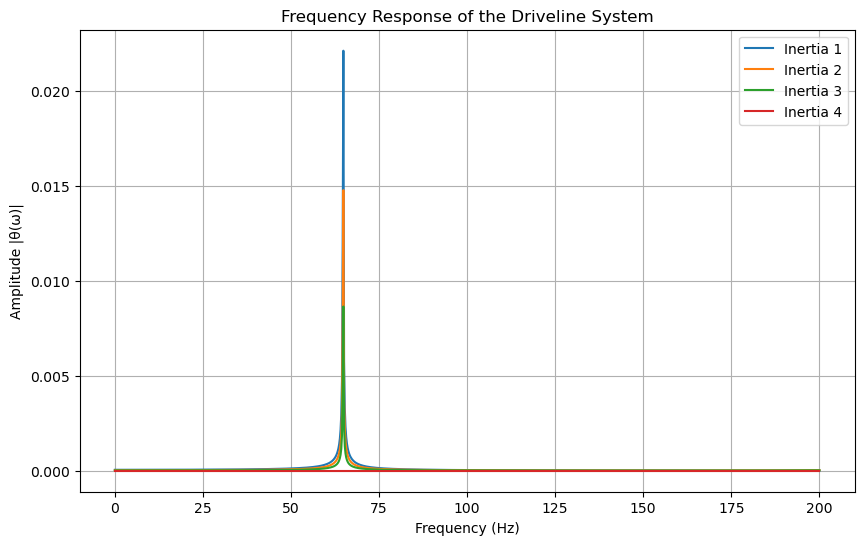

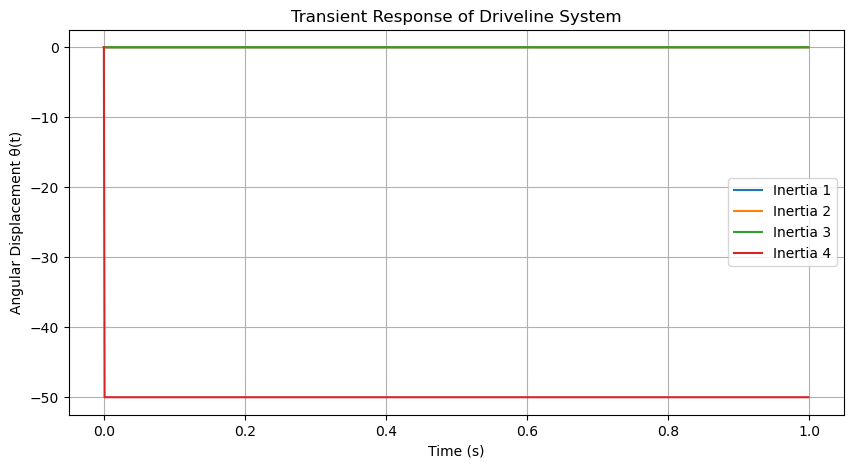

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, solve

###############################################################################
# SYSTEM PARAMETERS (Engine + Driveline Model)
###############################################################################

# Define the system components
J = np.array([0.1, 0.05, 0.02, 0.15])  # Moments of inertia (kg.m^2)
k = np.array([50000, 80000, 60000])  # Torsional stiffnesses (Nm/rad)
N = len(J)  # Number of inertias

# Define excitation torque (from gas pressure) applied at the crankshaft
T_engine = lambda t: 100 * np.sin(2 * np.pi * 50 * t)  # Example sinusoidal torque

# Define opposing torque at rear wheel (due to road friction)
T_resist = -50  # Constant opposing torque (Nm)

###############################################################################
# SYSTEM MATRIX ASSEMBLY (Equations of Motion)
###############################################################################

def assemble_matrices(J, k):
    N = len(J)
    M = np.diag(J)  # Mass matrix
    K = np.zeros((N, N))  # Stiffness matrix
    
    # Populate stiffness matrix for chain-like system
    for i in range(N - 1):
        K[i, i] += k[i]
        K[i, i + 1] -= k[i]
        K[i + 1, i] -= k[i]
        K[i + 1, i + 1] += k[i]
    
    # Apply boundary condition (fix rear wheel angular displacement)
    K[-1, :] = 0  # Zero the last row
    K[:, -1] = 0  # Zero the last column
    K[-1, -1] = 1  # Fix last inertia
    
    return M, K

M, K = assemble_matrices(J, k)

###############################################################################
# FREQUENCY DOMAIN ANALYSIS (NATURAL FREQUENCIES & MODES)
###############################################################################

def compute_natural_frequencies(M, K):
    eigvals, eigvecs = eigh(K, M)
    omega_n = np.sqrt(eigvals)  # Natural frequencies (rad/s)
    f_n = omega_n / (2 * np.pi)  # Convert to Hz
    return f_n, eigvecs

f_n, mode_shapes = compute_natural_frequencies(M, K)
print("Natural Frequencies (Hz):", f_n)

###############################################################################
# FREQUENCY RESPONSE FUNCTION (FRF) ANALYSIS
###############################################################################

# Define frequency range
f_vals = np.linspace(0.1, 200, 1000)  # Hz
w_vals = 2 * np.pi * f_vals  # Convert to rad/s

# Compute FRF
FRF = np.zeros((N, len(w_vals)), dtype=complex)
for i, w in enumerate(w_vals):
    A = K - w**2 * M  # Dynamic stiffness matrix
    F = np.zeros(N, dtype=complex)
    F[0] = 1  # Unit torque excitation at crankshaft
    theta = solve(A, F)  # Solve for angular displacements
    FRF[:, i] = theta

###############################################################################
# PLOTTING RESULTS
###############################################################################

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(f_vals, np.abs(FRF[i, :]), label=f'Inertia {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude |θ(ω)|')
plt.title('Frequency Response of the Driveline System')
plt.legend()
plt.grid()
plt.show()

###############################################################################
# TRANSIENT RESPONSE SIMULATION
###############################################################################

def simulate_response(J, k, T_engine, T_resist, t_max=1, dt=0.001):
    t = np.arange(0, t_max, dt)
    
    M, K = assemble_matrices(J, k)
    
    theta = np.zeros((N, len(t)))
    omega = np.zeros((N, len(t)))
    
    for i in range(1, len(t)):
        F = np.zeros(N)
        F[0] = T_engine(t[i])  # Engine excitation
        F[-1] += T_resist  # Opposing torque at rear wheel
        
        A = K
        
        theta[:, i] = solve(A, F)
        omega[:, i] = (theta[:, i] - theta[:, i - 1]) / dt
    
    return t, theta, omega

t, theta, omega = simulate_response(J, k, T_engine, T_resist)

# Plot angular displacement over time
plt.figure(figsize=(10, 5))
for i in range(N):
    plt.plot(t, theta[i, :], label=f'Inertia {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement θ(t)')
plt.title('Transient Response of Driveline System')
plt.legend()
plt.grid()
plt.show()


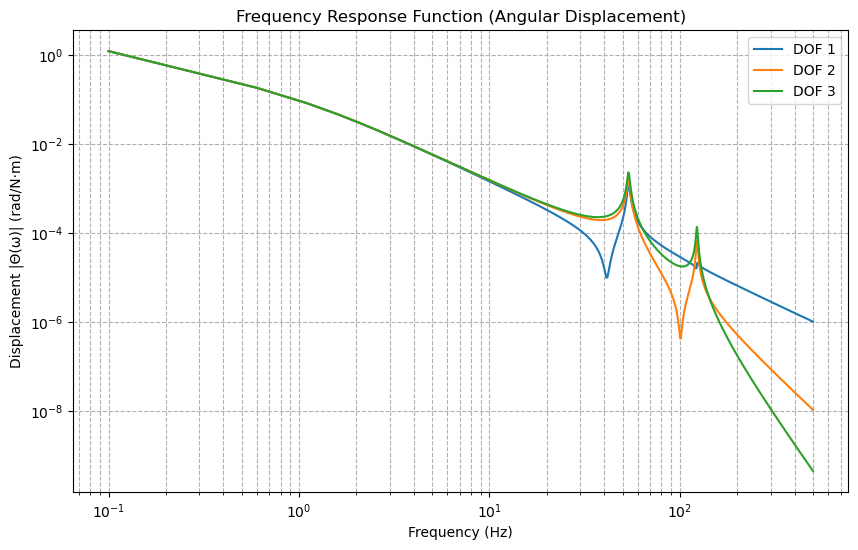

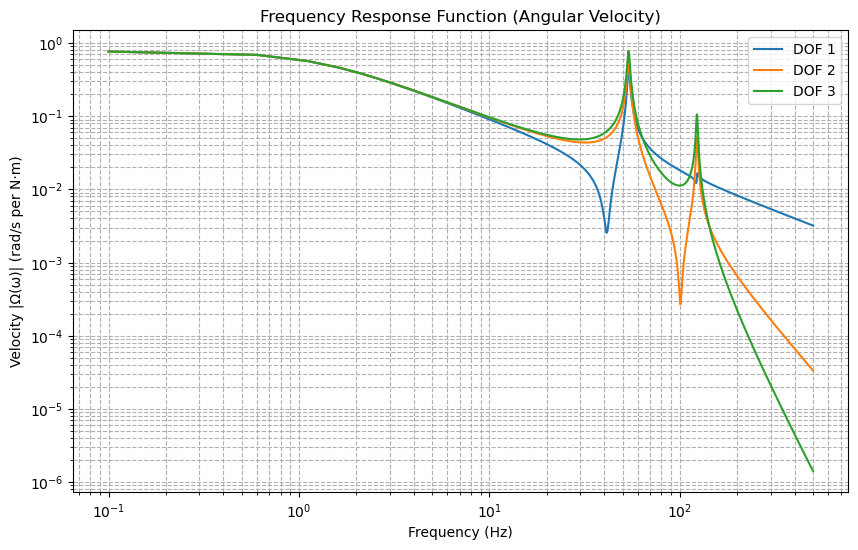

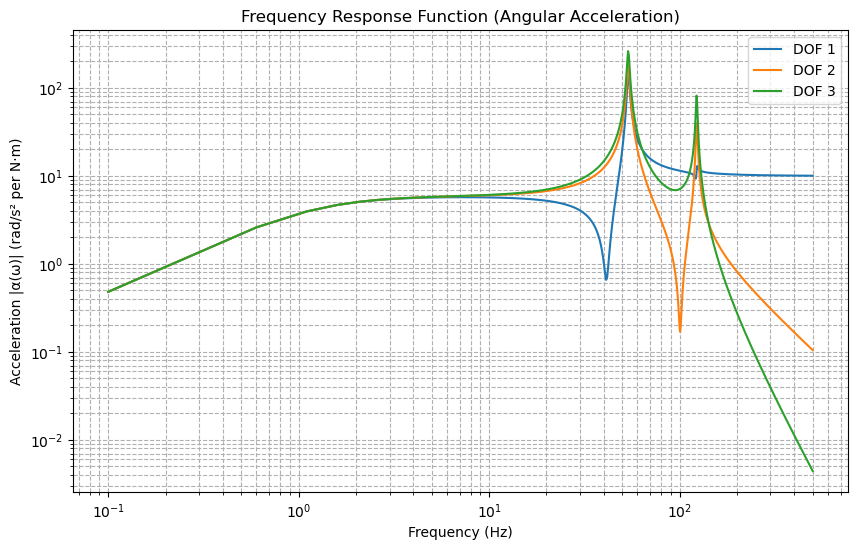

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Torsional system parameters
I = np.array([0.1, 0.05, 0.02])  # Inertias (kg·m²)
C = np.array([0.5, 0.3])  # Damping coefficients (N·m·s/rad)
K = np.array([5000, 8000])  # Stiffnesses (N·m/rad)

# Frequency range for FRF analysis
f_vals = np.linspace(0.1, 500, 1000)  # Frequency range (Hz)
w_vals = 2 * np.pi * f_vals  # Convert to rad/s

def compute_FRF(I, C, K, w_vals):
    """
    Compute the Frequency Response Function (FRF) for an N-DOF torsional system.
    Returns the angular displacement, velocity, and acceleration responses.
    """
    N = len(I)  # Number of inertias
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)  # Angular displacement
    W_vals = np.zeros((N, len(w_vals)), dtype=complex)  # Angular velocity
    A_vals = np.zeros((N, len(w_vals)), dtype=complex)  # Angular acceleration

    for idx, w in enumerate(w_vals):
        # Construct system impedance matrix: Z(w) = -w^2 * I + j*w*C + K
        Z = np.zeros((N, N), dtype=complex)

        # First inertia (connected to external torque)
        Z[0, 0] = -w**2 * I[0] + 1j * w * C[0] + K[0]
        Z[0, 1] = -K[0]

        for i in range(1, N - 1):
            Z[i, i - 1] = -K[i - 1]
            Z[i, i] = -w**2 * I[i] + 1j * w * C[i - 1] + K[i - 1] + K[i]
            Z[i, i + 1] = -K[i]

        # Last inertia (rear wheel, connected to previous inertia)
        Z[N - 1, N - 2] = -K[N - 2]
        Z[N - 1, N - 1] = -w**2 * I[N - 1] + 1j * w * C[N - 2] + K[N - 2]

        # External forcing: unit torque applied at inertia 1
        T_ext = np.zeros(N, dtype=complex)
        T_ext[0] = 1.0  # Unit torque excitation at crankshaft

        # Solve for angular displacements
        X = np.linalg.solve(Z, T_ext)

        # Compute velocity and acceleration in frequency domain
        W = 1j * w * X  # Angular velocity
        A = (1j * w) * W  # Angular acceleration

        X_vals[:, idx] = X
        W_vals[:, idx] = W
        A_vals[:, idx] = A

    return X_vals, W_vals, A_vals

# Compute FRF
X_vals, W_vals, A_vals = compute_FRF(I, C, K, w_vals)

# Plot the Frequency Response Function (FRF) - Magnitude
plt.figure(figsize=(10, 6))
for i in range(len(I)):
    plt.loglog(f_vals, np.abs(X_vals[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Displacement |Θ(ω)| (rad/N·m)')
plt.title('Frequency Response Function (Angular Displacement)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

# Plot Angular Velocity FRF
plt.figure(figsize=(10, 6))
for i in range(len(I)):
    plt.loglog(f_vals, np.abs(W_vals[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Velocity |Ω(ω)| (rad/s per N·m)')
plt.title('Frequency Response Function (Angular Velocity)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

# Plot Angular Acceleration FRF
plt.figure(figsize=(10, 6))
for i in range(len(I)):
    plt.loglog(f_vals, np.abs(A_vals[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Acceleration |α(ω)| (rad/s² per N·m)')
plt.title('Frequency Response Function (Angular Acceleration)')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()


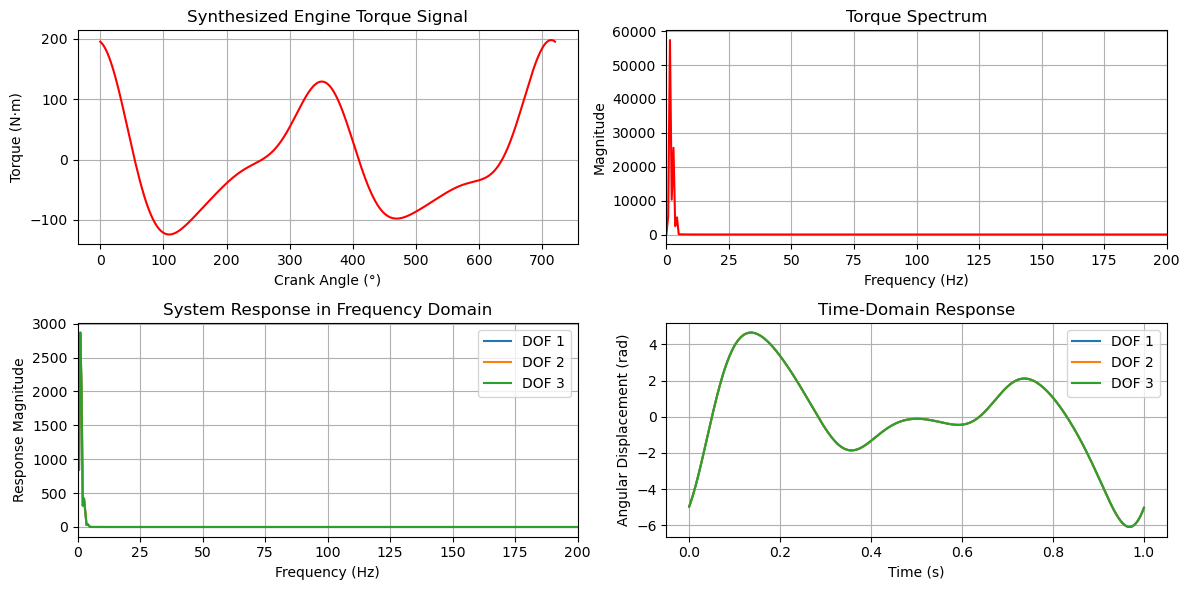

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# --- System Parameters ---
I = np.array([0.1, 0.05, 0.02])  # Inertias (kg·m²)
C = np.array([0.5, 0.3])  # Damping coefficients (N·m·s/rad)
K = np.array([5000, 8000])  # Stiffnesses (N·m/rad)

# --- Frequency Range ---
f_min, f_max, num_points = 0.1, 500, 1000
f_vals = np.linspace(f_min, f_max, num_points)  # Frequency range (Hz)
w_vals = 2 * np.pi * f_vals  # Convert to rad/s

# --- Input Torque Signal Synthesis ---
def synthesize_periodic_signal(harmonics, num_points=1024):
    """Synthesizes a periodic signal from harmonic components."""
    theta = np.linspace(0, 720, num_points)  # Angular positions (degrees)
    signal = np.zeros_like(theta, dtype=np.float64)
    
    for order, real, imag in harmonics:
        magnitude = np.sqrt(real**2 + imag**2)
        phase = np.arctan2(imag, real)
        signal += magnitude * np.cos(np.radians(order * theta) + phase)
    
    return theta, signal

# Example harmonics for a synthesized engine torque signal
harmonics = [
    (0.5, 10, 0), (1, 100, 50), (1.5, 20, 0),
    (2, 50, 0), (2.5, 5, 0), (3, 10, 0)
]
theta, torque_signal = synthesize_periodic_signal(harmonics, num_points=1024)

# --- Compute Torque Spectrum ---
torque_fft = fft(torque_signal)
freqs = fftfreq(len(torque_signal), d=1/720)  # Frequency axis (assuming 720 deg/cycle)
torque_spectrum = np.abs(torque_fft)[:len(freqs)//2]  # Take positive frequencies only
freqs = freqs[:len(freqs)//2]  # Remove negative frequencies

# --- Compute FRF ---
def compute_FRF(I, C, K, w_vals):
    """Computes the Frequency Response Function (FRF) for a torsional system."""
    N = len(I)
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)

    for idx, w in enumerate(w_vals):
        Z = np.zeros((N, N), dtype=complex)

        # First inertia
        Z[0, 0] = -w**2 * I[0] + 1j * w * C[0] + K[0]
        Z[0, 1] = -K[0]

        for i in range(1, N - 1):
            Z[i, i - 1] = -K[i - 1]
            Z[i, i] = -w**2 * I[i] + 1j * w * C[i - 1] + K[i - 1] + K[i]
            Z[i, i + 1] = -K[i]

        # Last inertia
        Z[N - 1, N - 2] = -K[N - 2]
        Z[N - 1, N - 1] = -w**2 * I[N - 1] + 1j * w * C[N - 2] + K[N - 2]

        T_ext = np.zeros(N, dtype=complex)
        T_ext[0] = 1.0  # Unit torque excitation at crankshaft

        X = np.linalg.solve(Z, T_ext)
        X_vals[:, idx] = X

    return X_vals

X_vals = compute_FRF(I, C, K, w_vals)

# --- Compute System Response to Actual Torque Spectrum ---
def compute_response_to_torque(FRF, torque_spectrum, freqs, f_vals):
    """Computes the system response by multiplying the FRF with the actual torque spectrum."""
    response_spectrum = np.zeros_like(FRF, dtype=complex)

    for i in range(len(I)):
        # Interpolate the torque spectrum to match FRF frequencies
        interpolated_torque = np.interp(f_vals, freqs, torque_spectrum, left=0, right=0)
        
        # Compute system response
        response_spectrum[i, :] = FRF[i, :] * interpolated_torque
    
    return response_spectrum

X_response = compute_response_to_torque(X_vals, torque_spectrum, freqs, f_vals)

# --- Convert Response Back to Time Domain (Inverse FFT) ---
time_response = ifft(X_response, axis=1)

# --- Plot Results ---
plt.figure(figsize=(12, 6))

# Plot original synthesized torque
plt.subplot(2, 2, 1)
plt.plot(theta, torque_signal, color='red')
plt.xlabel('Crank Angle (°)')
plt.ylabel('Torque (N·m)')
plt.title('Synthesized Engine Torque Signal')
plt.grid()

# Plot torque spectrum
plt.subplot(2, 2, 2)
plt.plot(freqs, torque_spectrum, color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Torque Spectrum')
plt.xlim(0, 200)
plt.grid()

# Plot FRF-multiplied response in the frequency domain
plt.subplot(2, 2, 3)
for i in range(len(I)):
    plt.plot(f_vals, np.abs(X_response[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response Magnitude')
plt.title('System Response in Frequency Domain')
plt.legend()
plt.xlim(0, 200)
plt.grid()

# Plot reconstructed time-domain response
plt.subplot(2, 2, 4)
time_axis = np.linspace(0, 1, len(time_response[0]))  # Simulated time axis
for i in range(len(I)):
    plt.plot(time_axis, np.real(time_response[i, :]), label=f'DOF {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement (rad)')
plt.title('Time-Domain Response')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


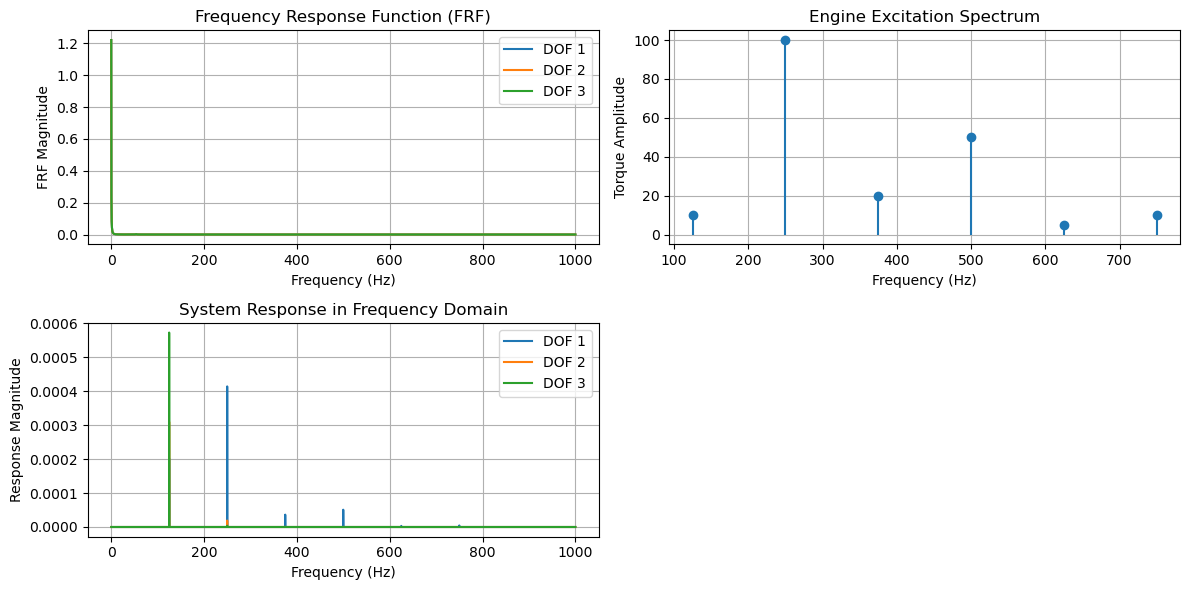

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
I = np.array([0.1, 0.05, 0.02])  # Inertias (kg·m²)
C = np.array([0.5, 0.3])  # Damping coefficients (N·m·s/rad)
K = np.array([5000, 8000])  # Stiffnesses (N·m/rad)

# --- Define Engine Speed & Base Frequency ---
engine_rpm = 15000  # Engine Speed in RPM
f_base = engine_rpm / 60  # Base frequency (Hz)

# --- Define Harmonic Orders and Relative Amplitudes ---
harmonics = [
    (0.5, 10),  # Order 0.5
    (1, 100),   # Order 1
    (1.5, 20),  # Order 1.5
    (2, 50),    # Order 2
    (2.5, 5),   # Order 2.5
    (3, 10)     # Order 3
]

# --- Convert Orders to Frequencies and Store Amplitudes ---
f_harmonics = np.array([order * f_base for order, _ in harmonics])  # Convert orders to Hz
T_harmonics = np.array([amplitude for _, amplitude in harmonics])   # Corresponding amplitudes

# --- Frequency Range for FRF ---
f_min, f_max, num_points = 0.1, 1000, 5000
f_vals = np.linspace(f_min, f_max, num_points)  # Frequency range (Hz)
w_vals = 2 * np.pi * f_vals  # Convert to rad/s

# --- Compute FRF ---
def compute_FRF(I, C, K, w_vals):
    """Computes the Frequency Response Function (FRF) for a torsional system."""
    N = len(I)
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)

    for idx, w in enumerate(w_vals):
        Z = np.zeros((N, N), dtype=complex)

        # First inertia
        Z[0, 0] = -w**2 * I[0] + 1j * w * C[0] + K[0]
        Z[0, 1] = -K[0]

        for i in range(1, N - 1):
            Z[i, i - 1] = -K[i - 1]
            Z[i, i] = -w**2 * I[i] + 1j * w * C[i - 1] + K[i - 1] + K[i]
            Z[i, i + 1] = -K[i]

        # Last inertia
        Z[N - 1, N - 2] = -K[N - 2]
        Z[N - 1, N - 1] = -w**2 * I[N - 1] + 1j * w * C[N - 2] + K[N - 2]

        T_ext = np.zeros(N, dtype=complex)
        T_ext[0] = 1.0  # Unit torque excitation at crankshaft

        X = np.linalg.solve(Z, T_ext)
        X_vals[:, idx] = X

    return X_vals

H_vals = compute_FRF(I, C, K, w_vals)

# --- Compute System Response to Actual Excitation Spectrum ---
def compute_response_superposition(FRF, f_vals, f_harmonics, T_harmonics):
    """Computes the system response by summing up contributions from all harmonics."""
    response_spectrum = np.zeros_like(FRF, dtype=complex)

    for i in range(len(I)):
        for j in range(len(f_harmonics)):
            # Find the nearest frequency in f_vals
            nearest_idx = np.argmin(np.abs(f_vals - f_harmonics[j]))

            # Superimpose contributions
            response_spectrum[i, nearest_idx] += FRF[i, nearest_idx] * T_harmonics[j]
    
    return response_spectrum

X_response = compute_response_superposition(H_vals, f_vals, f_harmonics, T_harmonics)

# --- Plot Results ---
plt.figure(figsize=(12, 6))

# Plot FRF
plt.subplot(2, 2, 1)
for i in range(len(I)):
    plt.plot(f_vals, np.abs(H_vals[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FRF Magnitude')
plt.title('Frequency Response Function (FRF)')
plt.legend()
plt.grid()

# Plot Input Torque Spectrum
plt.subplot(2, 2, 2)
plt.stem(f_harmonics, T_harmonics, basefmt=" ")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Torque Amplitude')
plt.title('Engine Excitation Spectrum')
plt.grid()

# Plot System Response Spectrum
plt.subplot(2, 2, 3)
for i in range(len(I)):
    plt.plot(f_vals, np.abs(X_response[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response Magnitude')
plt.title('System Response in Frequency Domain')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


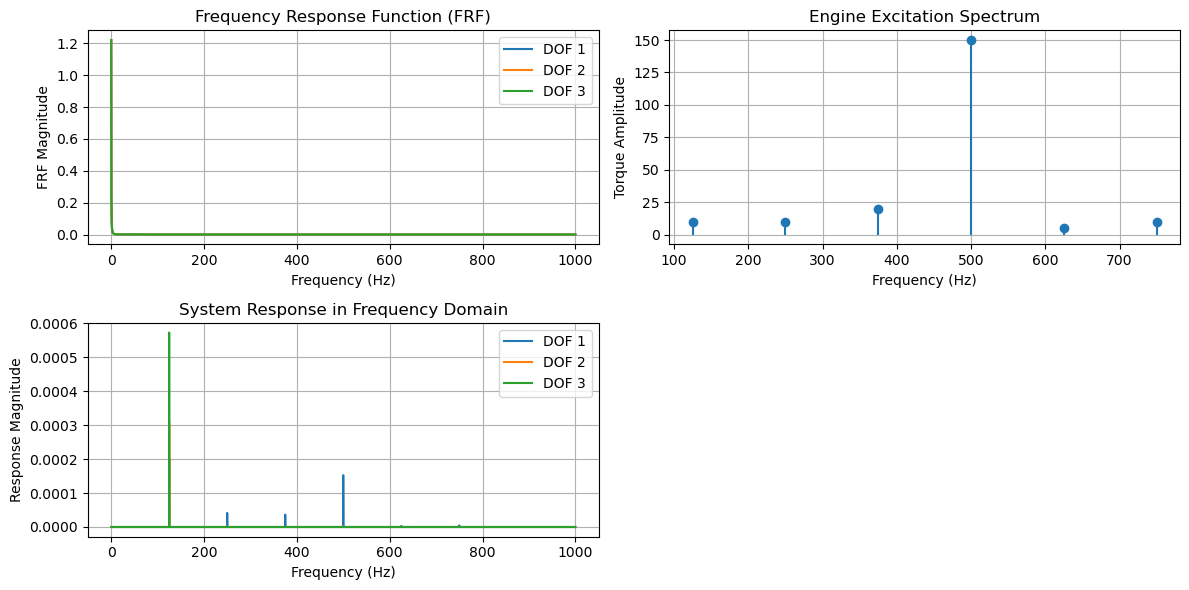

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
I = np.array([0.1, 0.05, 0.02])  # Inertias (kg·m²)
C = np.array([0.5, 0.3])  # Damping coefficients (N·m·s/rad)
K = np.array([5000, 8000])  # Stiffnesses (N·m/rad)

# --- Define Engine Speed & Base Frequency ---
engine_rpm = 15000  # Engine Speed in RPM
f_base = engine_rpm / 60  # Base frequency (Hz)

# --- Define Harmonic Orders and Relative Amplitudes ---
harmonics = [
    (0.5, 10),  # Order 0.5
    (1, 10),   # Order 1
    (1.5, 20),  # Order 1.5
    (2, 150),    # Order 2
    (2.5, 5),   # Order 2.5
    (3, 10)     # Order 3
]

# --- Convert Orders to Frequencies and Store Amplitudes ---
f_harmonics = np.array([order * f_base for order, _ in harmonics])  # Convert orders to Hz
T_harmonics = np.array([amplitude for _, amplitude in harmonics])   # Corresponding amplitudes

# --- Frequency Range for FRF ---
f_min, f_max, num_points = 0.1, 1000, 5000
f_vals = np.linspace(f_min, f_max, num_points)  # Frequency range (Hz)
w_vals = 2 * np.pi * f_vals  # Convert to rad/s

# --- Compute FRF ---
def compute_FRF(I, C, K, w_vals):
    """Computes the Frequency Response Function (FRF) for a torsional system."""
    N = len(I)
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)

    for idx, w in enumerate(w_vals):
        Z = np.zeros((N, N), dtype=complex)

        # First inertia
        Z[0, 0] = -w**2 * I[0] + 1j * w * C[0] + K[0]
        Z[0, 1] = -K[0]

        for i in range(1, N - 1):
            Z[i, i - 1] = -K[i - 1]
            Z[i, i] = -w**2 * I[i] + 1j * w * C[i - 1] + K[i - 1] + K[i]
            Z[i, i + 1] = -K[i]

        # Last inertia
        Z[N - 1, N - 2] = -K[N - 2]
        Z[N - 1, N - 1] = -w**2 * I[N - 1] + 1j * w * C[N - 2] + K[N - 2]

        T_ext = np.zeros(N, dtype=complex)
        T_ext[0] = 1.0  # Unit torque excitation at crankshaft

        X = np.linalg.solve(Z, T_ext)
        X_vals[:, idx] = X

    return X_vals

H_vals = compute_FRF(I, C, K, w_vals)

# --- Compute System Response to Actual Excitation Spectrum ---
def compute_response_superposition(FRF, f_vals, f_harmonics, T_harmonics):
    """Computes the system response by summing up contributions from all harmonics."""
    response_spectrum = np.zeros_like(FRF, dtype=complex)

    for i in range(len(I)):
        for j in range(len(f_harmonics)):
            # Find the nearest frequency in f_vals
            nearest_idx = np.argmin(np.abs(f_vals - f_harmonics[j]))

            # Superimpose contributions
            response_spectrum[i, nearest_idx] += FRF[i, nearest_idx] * T_harmonics[j]
    
    return response_spectrum

X_response = compute_response_superposition(H_vals, f_vals, f_harmonics, T_harmonics)

# --- Plot Results ---
plt.figure(figsize=(12, 6))

# Plot FRF
plt.subplot(2, 2, 1)
for i in range(len(I)):
    plt.plot(f_vals, np.abs(H_vals[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FRF Magnitude')
plt.title('Frequency Response Function (FRF)')
plt.legend()
plt.grid()

# Plot Input Torque Spectrum
plt.subplot(2, 2, 2)
plt.stem(f_harmonics, T_harmonics, basefmt=" ")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Torque Amplitude')
plt.title('Engine Excitation Spectrum')
plt.grid()

# Plot System Response Spectrum
plt.subplot(2, 2, 3)
for i in range(len(I)):
    plt.plot(f_vals, np.abs(X_response[i, :]), label=f'DOF {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response Magnitude')
plt.title('System Response in Frequency Domain')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (5000,) and (1000,)

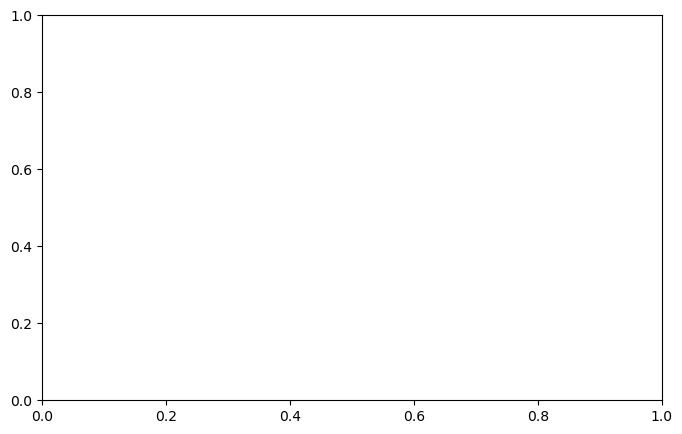

In [13]:
# Reference DOF (e.g., DOF 0 - Crankshaft)
ref_dof = 0  

# Correct the shape of phase_diff (Num_DOFs, Num_Frequencies)
num_dofs, num_frequencies = X_vals.shape
phase_diff = np.zeros((num_dofs, num_frequencies))  

# Compute phase differences (avoid division by zero)
for i in range(num_dofs):
    valid_indices = X_vals[ref_dof, :] != 0  # Avoid division by zero
    phase_diff[i, valid_indices] = np.angle(X_vals[i, valid_indices] / X_vals[ref_dof, valid_indices], deg=True)

# Plot Phase Relationships
plt.figure(figsize=(8, 5))
for i in range(num_dofs):
    if i != ref_dof:
        plt.plot(f_vals, phase_diff[i, :], label=f'Phase diff: DOF {i+1} vs DOF {ref_dof+1}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Difference (degrees)')
plt.title('Phase Difference Relative to Crankshaft')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()
